# Wrangle and Analyze Data
## Explore data from "WeRateDogs<sup>TM</sup>(@dog_rates)"

## Introduction 

Real-world data rarely comes clean. Using Python and its libraries, you will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called **data wrangling**. I will document my wrangling efforts in the following Jupyter Notebook, plus showcase them through analyses and visualizations using Python (and its libraries) and/or SQL.

The dataset that I wrangled (and analyzed and visualized) is the **tweet archive** of Twitter user **@dog_rates**, also known as **WeRateDogs**. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

## Project Motivation
### Context

- **Goal**: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.


- **Data**:
    - Enhanced Twitter Archive
        - The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced."
       
       
- **Additional Data via the Twitter API**
    - Back to the basicness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. We have the WeRateDogs Twitter archive and specifically the tweet IDs within it, can gather this data for all 5000+. I'am going to query Twitter's API to gather this valuable data.
    
    
- **Image Predictions File**
    - One more cool thing: I ran every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs*. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

## Data wrangling
### 1. Gathering Data 

In [311]:
# Necessary import 
import os
import re 
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import matplotlib.pyplot as plt 
import time
from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid", font_scale=1.2);

The WeRateDogs Twitter archive file is directly given. Download this file manually by clicking the following link: [twitter_archive_enhanced.csv](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv) and store to my project path.

In [2]:
# Read csv file: "The WeRateDogs Twitter archive"
archive = pd.read_csv("twitter-archive-enhanced.csv", encoding='latin-1')

In [11]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [14]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [3]:
# Read tsv file: "image_predictions.tsv"
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(url.split("/")[-1], mode = 'wb') as file:
    file.write(response.content)
image_predictions = pd.read_csv("image-predictions.tsv", sep = '\t')

In [5]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [15]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the **tweet IDs** in the _WeRateDogs_ Twitter archive, **query the Twitter API for each tweet's JSON data** using Python's [**Tweepy**](http://www.tweepy.org/) library and store each tweet's entire set of JSON data in a file called **tweet_json.txt** file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) **tweet ID, retweet count, and favorite count**. 

<span style="color:red">_Note_:</span> Do not include your Twitter API keys, secrets, and tokens.

In [8]:
consumer_key = '...'
consumer_secret = '...'
access_token = '...'
access_token_secret = '...'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Construct the API instance
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), # Parse the result to Json Object
                 wait_on_rate_limit = True, # Automatically wait for rate limits to replenish
                 wait_on_rate_limit_notify = True) # Print a notification when Tweepy is waiting for rate limits to replenish

In [10]:
# Get one page to see how the structure of the returned file and names of attibutes look like
page = api.get_status(archive['tweet_id'][0])
page

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'entities': {'hashtags': [],
  'media': [{'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'sizes': {'large': {'h': 528, 'resize': 'fit', 'w': 540},
     'medium': {'h': 528, 'resize': 'fit', 'w': 540},
     'small': {'h': 528, 'resize': 'fit', 'w': 540},
     'thumb': {'h': 150, 'resize': 'crop', 'w': 150}},
    'type': 'photo',
    'url': 'https://t.co/MgUWQ76dJU'}],
  'symbols': [],
  'urls': [],
  'user_mentions': []},
 'extended_entities': {'media': [{'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/ph

In [16]:
# Get the tweet object for all the teweets in archive dataframe 
df_list = []
error_list = []
# Calculate the time of excution
start = time.time()
for tweet_id in archive['tweet_id']:
    try:
        page = api.get_status(tweet_id, tweet_mode = 'extended')
        favorites = page['favorite_count'] # How many favorites the tweet had
        retweets = page['retweet_count'] # Count of the retweet
        user_followers = page['user']['followers_count'] # How many followers the user had
        user_favourites = page['user']['favourites_count'] # How many favorites the user had
        user_friends = page['user']['friends_count'] # How many friends the user had
        create_time = page['created_at'] # The time of the creation
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'user_friends':int(user_friends),
                        'date_time': pd.to_datetime(create_time)})
    
    # Catch the exceptions of the TweepError
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        error_list.append(tweet_id)

# Calculate the time of excution
end = time.time()
print(end - start)

888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 _ [{'code': 144, 'message': 'No status found with that ID.'}]
802247111496568832 _ [{'code': 144, 'message': 'No status found with that ID.'}]
775096608509886464 _ [{'code': 144, 'message': 'No status found with that ID.'}]
Rate limit reached. Sleeping for: 310
Rate limit reached. Sleeping for: 646
1656.8036968708038


In [17]:
print(len(df_list), len(error_list))

2348 8


In [18]:
# Create DataFrames from the list of dictionaries 
tweet_json = pd.DataFrame(df_list, columns=['tweet_id', 'favorites','retweets','user_followers','user_favourites','user_friends','date_time'])

# Save the created DataFrame to txt file
tweet_json.to_csv('tweet_json.txt', encoding='utf-8', index = False)

In [19]:
tweet = pd.read_csv('tweet_json.txt')

In [23]:
tweet.head()

,tweet_id,favorites,retweets,user_followers,user_favourites,user_friends,date_time
0,892420643555336193,39164,8720,5413017,129564,103,2017-08-01 16:23:56
1,892177421306343426,33546,6400,5413017,129564,103,2017-08-01 00:17:27
2,891815181378084864,25277,4254,5413018,129564,103,2017-07-31 00:18:03
3,891689557279858688,42535,8816,5413018,129564,103,2017-07-30 15:58:51
4,891327558926688256,40712,9600,5413018,129564,103,2017-07-29 16:00:24


In [21]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348 entries, 0 to 2347
Data columns (total 7 columns):
tweet_id           2348 non-null int64
favorites          2348 non-null int64
retweets           2348 non-null int64
user_followers     2348 non-null int64
user_favourites    2348 non-null int64
user_friends       2348 non-null int64
date_time          2348 non-null object
dtypes: int64(6), object(1)
memory usage: 128.5+ KB


**Gathering Data Summary**

- **Obtain**
    - The WeRateDogs Twitter archive which is a file on hand, and I download manually by clicking the following link: [twitter_archive_enhanced.csv](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv)
    - The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and I downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
    - Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's [Tweepy](http://www.tweepy.org/) library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data was written to its own line. Then read this .txt file line by line into a pandas DataFrame with tweet ID, favorite count, retweet count, user followers, user favourites, user friends, and data time. 

- **Read**
    - Import the data to the Jupyter Notebook 

### 2. Assessing data

In [24]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [25]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be intergs instead of float
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be changed to string because we don't use them for any numerical calculation
- retweeted_status_timestamp, timestamp should be datetime instead of object (string)

In [26]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [27]:
print(archive['text'].sample(7))

1541    This is Lucy. She's terrified of the stuffed b...
210     This is Sailor. He has collected the best dirt...
1813    When someone yells "cops!" at a party and you ...
1444    This is Trevith. He's a Swiss Mountain Roadwoo...
769     This is Jeffrey. He's being held so he doesn't...
1661    This is Lulu. She's contemplating all her unre...
1362    This is an East African Chalupa Seal. We only ...
Name: text, dtype: object


- Can add a 'gender' column

In [28]:
archive.rating_numerator.sort_values()

315        0
1016       0
2335       1
2261       1
2338       1
605        1
1446       1
1869       1
2091       1
2038       1
1940       1
1764       2
2310       2
1761       2
1920       2
2246       2
2237       2
2349       2
2326       2
2079       2
2305       3
1249       3
1898       3
1478       3
1692       3
2202       3
765        3
1928       3
1314       3
2183       3
        ... 
866       14
83        14
291       15
285       15
55        17
1663      20
516       24
1712      26
763       27
1433      44
1274      45
1202      50
1351      60
340       75
695       75
1254      80
433       84
1843      88
1228      99
1635     121
1634     143
1779     144
902      165
290      182
1120     204
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

In [29]:
archive[archive['rating_numerator']==1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [30]:
archive.rating_denominator.sort_values()

313       0
2335      2
516       7
1576     10
1575     10
1574     10
1573     10
1572     10
1563     10
1570     10
1569     10
1568     10
1567     10
1566     10
1565     10
1564     10
1577     10
1571     10
0        10
1562     10
1547     10
1548     10
1549     10
1550     10
1551     10
1552     10
1553     10
1554     10
1555     10
1556     10
       ... 
782      10
781      10
775      10
799      10
780      10
779      10
776      10
777      10
778      10
800      10
784      11
1068     11
1662     11
342      15
1663     16
1165     20
1598     20
1433     40
1202     50
1351     50
1274     50
433      70
1843     80
1254     80
1228     90
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [31]:
archive[archive['rating_denominator']==0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


- The numerator and denominator columns have invalid values, the numerator may have outliers and the denominator minimum shows 0 which is invalid.

In [33]:
archive.tweet_id.nunique()

2356

In [34]:
archive[archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [35]:
archive.name.sample(7)

1781    Sadie
2258     None
1163     Ivar
357      Kyro
1871     None
7        None
770      None
Name: name, dtype: object

In [36]:
archive.name.value_counts()

None        745
a            55
Charlie      12
Lucy         11
Cooper       11
Oliver       11
Tucker       10
Penny        10
Lola         10
Bo            9
Winston       9
the           8
Sadie         8
an            7
Bailey        7
Daisy         7
Toby          7
Buddy         7
Koda          6
Leo           6
Dave          6
Oscar         6
Scout         6
Bella         6
Milo          6
Jack          6
Rusty         6
Stanley       6
Jax           6
Larry         5
           ... 
Kendall       1
Gustav        1
Bodie         1
Autumn        1
Boots         1
Livvie        1
Pilot         1
Claude        1
Kingsley      1
Kulet         1
Wiggles       1
Bronte        1
Bruno         1
Rizzo         1
Chuq          1
Cheryl        1
Clifford      1
Georgie       1
Mookie        1
Pluto         1
Iroh          1
Strudel       1
RalphÃ©       1
Bluebert      1
Marq          1
Rolf          1
Pip           1
Clybe         1
Emanuel       1
Dixie         1
Name: name, Length: 957,

- "name" column has invaled name such as "None, a, an, the"

In [37]:
sum(archive.in_reply_to_status_id.isnull()) + archive.in_reply_to_status_id.count() == 2356

True

In [38]:
sum(archive.in_reply_to_user_id.isnull()) + archive.in_reply_to_user_id.count() == 2356

True

In [39]:
sum(archive.retweeted_status_id.isnull()) + archive.retweeted_status_id.count() == 2356

True

In [40]:
sum(archive.retweeted_status_user_id.isnull()) + archive.retweeted_status_user_id.count() == 2356

True

In [41]:
sum(archive.retweeted_status_timestamp.isnull()) + archive.retweeted_status_timestamp.count() == 2356

True

In [42]:
sum(archive.expanded_urls.isnull())+archive.expanded_urls.count() == 2356

True

In [44]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [45]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


- Missing values from images dataset (2075 rows instead of 2356 compared to df_archive)

In [46]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [47]:
image_predictions[image_predictions.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [49]:
image_predictions['jpg_url'].nunique()

2009

In [50]:
image_predictions['jpg_url'].value_counts()

https://pbs.twimg.com/media/CtzKC7zXEAALfSo.jpg                                            2
https://pbs.twimg.com/media/Crwxb5yWgAAX5P_.jpg                                            2
https://pbs.twimg.com/media/CiibOMzUYAA9Mxz.jpg                                            2
https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg                                            2
https://pbs.twimg.com/media/CvaYgDOWgAEfjls.jpg                                            2
https://pbs.twimg.com/media/CrXhIqBW8AA6Bse.jpg                                            2
https://pbs.twimg.com/media/CV_cnjHWUAADc-c.jpg                                            2
https://pbs.twimg.com/media/CtKHLuCWYAA2TTs.jpg                                            2
https://pbs.twimg.com/media/CvT6IV6WEAQhhV5.jpg                                            2
https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg                                            2
https://pbs.twimg.com/media/CVuQ2LeUsAAIe3s.jpg                       

In [51]:
image_predictions[image_predictions['jpg_url'] == 'https://pbs.twimg.com/media/CiibOMzUYAA9Mxz.jpg']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1150,732005617171337216,https://pbs.twimg.com/media/CiibOMzUYAA9Mxz.jpg,1,English_setter,0.677408,True,Border_collie,0.052724,True,cocker_spaniel,0.048572,True
1693,816014286006976512,https://pbs.twimg.com/media/CiibOMzUYAA9Mxz.jpg,1,English_setter,0.677408,True,Border_collie,0.052724,True,cocker_spaniel,0.048572,True


In [52]:
image_predictions[image_predictions.jpg_url.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1364,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7...,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True
1387,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.420463,True,miniature_poodle,0.132640,True,Chesapeake_Bay_retriever,0.121523,True
1407,770093767776997377,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True


In [53]:
tweet.head()

,tweet_id,favorites,retweets,user_followers,user_favourites,user_friends,date_time
0,892420643555336193,39164,8720,5413017,129564,103,2017-08-01 16:23:56
1,892177421306343426,33546,6400,5413017,129564,103,2017-08-01 00:17:27
2,891815181378084864,25277,4254,5413018,129564,103,2017-07-31 00:18:03
3,891689557279858688,42535,8816,5413018,129564,103,2017-07-30 15:58:51
4,891327558926688256,40712,9600,5413018,129564,103,2017-07-29 16:00:24


In [54]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348 entries, 0 to 2347
Data columns (total 7 columns):
tweet_id           2348 non-null int64
favorites          2348 non-null int64
retweets           2348 non-null int64
user_followers     2348 non-null int64
user_favourites    2348 non-null int64
user_friends       2348 non-null int64
date_time          2348 non-null object
dtypes: int64(6), object(1)
memory usage: 128.5+ KB


In [56]:
tweet.tweet_id.nunique()

2348

In [57]:
all_columns = pd.Series(list(archive) + list(image_predictions) + list(tweet))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

In [58]:
all_columns

0                       tweet_id
1          in_reply_to_status_id
2            in_reply_to_user_id
3                      timestamp
4                         source
5                           text
6            retweeted_status_id
7       retweeted_status_user_id
8     retweeted_status_timestamp
9                  expanded_urls
10              rating_numerator
11            rating_denominator
12                          name
13                         doggo
14                       floofer
15                        pupper
16                         puppo
17                      tweet_id
18                       jpg_url
19                       img_num
20                            p1
21                       p1_conf
22                        p1_dog
23                            p2
24                       p2_conf
25                        p2_dog
26                            p3
27                       p3_conf
28                        p3_dog
29                      tweet_id
30        

**Quality: (Completeness, Validity, Accuracy, Consistency)**

**archive table**
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be intergs instead of float
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be changed to string because we don't use them for any numerical calculation
- retweeted_status_timestamp, timestamp should be datetime instead of object (string)
- The numerator and denominator columns have invalid values, the numerator may have outliers and the denominator minimum shows 0 which is invalid
- "name" column has invaled name such as "None, a, an, the, this"
- In 'doggo', 'floofer', 'pupper', 'puppo' columns, null objects are non-null(None to NaN)
- Column 'timestamp' in df_archive is same as column 'date_time' in tweet
- Make 'source' column more clear to read
**image_predictions table**
- Missing values from images dataset (2075 rows instead of 2356 compared to df_archive)
- We only want original ratings (no retweets) that have images
- Some tweet_ids have the same jpg_url

**Tidiness (Untidy data)**
- Drop column related to retweets, and unnecessary columns in images table
- Various stages of dogs in columns, it is better to use rows archives dataset 
- Add a gender column from the text columns in archives dataset
All tables should be part of one dataset

### 3. Cleaning data

#### Tidiness

In [59]:
archive_clean = archive.copy()
images_clean = image_predictions.copy()
tweet_clean = tweet.copy()

In [60]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [61]:
images_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [62]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348 entries, 0 to 2347
Data columns (total 7 columns):
tweet_id           2348 non-null int64
favorites          2348 non-null int64
retweets           2348 non-null int64
user_followers     2348 non-null int64
user_favourites    2348 non-null int64
user_friends       2348 non-null int64
date_time          2348 non-null object
dtypes: int64(6), object(1)
memory usage: 128.5+ KB


Define
- Drop unnecessary columns related to retweets

Code

In [63]:
archive_clean = archive_clean.drop(['retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp'], 1)
tweet_clean = tweet_clean.drop(['retweets'], 1)

Test

In [64]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2356 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2356 non-null object
source                   2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null int64
rating_denominator       2356 non-null int64
name                     2356 non-null object
doggo                    2356 non-null object
floofer                  2356 non-null object
pupper                   2356 non-null object
puppo                    2356 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 257.8+ KB


In [65]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2348 entries, 0 to 2347
Data columns (total 6 columns):
tweet_id           2348 non-null int64
favorites          2348 non-null int64
user_followers     2348 non-null int64
user_favourites    2348 non-null int64
user_friends       2348 non-null int64
date_time          2348 non-null object
dtypes: int64(5), object(1)
memory usage: 110.1+ KB


Define
- Various stages of dogs in columns, it is better to use rows archives dataset, in another words: we should melt the 'doggo', 'floofer', 'pupper' and 'puppo' columns to single column which can be named as 'dog_stage'

Code

In [69]:
# Select the columns to melt and to remain
columns_melt = ['doggo', 'floofer', 'pupper', 'puppo']
columns_stay = [x for x in archive_clean.columns.tolist() if x not in columns_melt]

# Mlet the the columns into values
archive_melt = pd.melt(archive_clean, id_vars = columns_stay, value_vars = columns_melt, 
                         var_name = 'stages', value_name = 'dog_stage')

# Delete column 'stages'
archive_melt = archive_melt.drop('stages', 1)
archive_melt = archive_melt.sort_values('dog_stage').drop_duplicates('tweet_id', keep = 'last')

Test

In [70]:
len(archive_melt)

2356

In [71]:
archive_melt = archive_melt.reset_index(drop=True)

In [72]:
archive_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id                 2356 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2356 non-null object
source                   2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null int64
rating_denominator       2356 non-null int64
name                     2356 non-null object
dog_stage                2356 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 202.5+ KB


In [76]:
archive_melt.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
1007,677895101218201600,NaN,NaN,2015-12-18 16:56:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this was terrifying. Really spooked me up...,https://twitter.com/dog_rates/status/677895101...,9,10,None,None
404,690989312272396288,NaN,NaN,2016-01-23 20:07:44 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",We've got a doggy down. Requesting backup. 12/...,https://vine.co/v/iOZKZEU2nHq,12,10,None,None
1533,845812042753855489,NaN,NaN,2017-03-26 01:38:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We usually don't rate polar bears but this one...,https://twitter.com/dog_rates/status/845812042...,13,10,None,None
926,670823764196741120,NaN,NaN,2015-11-29 04:37:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Remington. He's a man dime. 12/10 http...,https://twitter.com/dog_rates/status/670823764...,12,10,Remington,None
1867,747594051852075008,NaN,NaN,2016-06-28 00:54:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Again w the sharks guys. This week is about do...,https://twitter.com/dog_rates/status/747594051...,11,10,None,None


Define
- Drop necessary columns in images_clean table

Code

In [78]:
images_clean.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [ ]:
algorithm_prediction = []
algorithm_confidential = []
def prediction(data):
    if data['p1_dog'] == True:
        algorithm_prediction.append(data['p1'])
        algorithm_confidential.append(data['p1_conf'])
    elif data['p2_dog'] == True:
        algorithm_prediction.append(data['p2'])
        algorithm_confidential.append(data['p2_conf'])
    elif data['p3_dog'] == True:
        algorithm_prediction.append(data['p3'])
        algorithm_confidential.append(data['p3_conf'])
    else:
        algorithm_prediction.append('NaN')
        algorithm_confidential.append(0)
images_clean.apply(prediction, axis = 1) #axis=1 apply function to each row 
images_clean['algorithm_prediction'] = algorithm_prediction
images_clean['algorithm_confidential'] = algorithm_confidential
images_clean = images_clean.drop(['p1','p1_conf', 'p1_dog','p2','p2_conf', 'p2_dog', 'p3','p3_conf', 'p3_dog'], axis=1)

In [80]:
images_clean = images_clean.drop(['img_num'],1)

Test

In [81]:
images_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id                  2075 non-null int64
jpg_url                   2075 non-null object
algorithm_prediction      2075 non-null object
algorithm_confidential    2075 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 64.9+ KB


Define
- Add a gender column from the text columns in archives dataset, search from the text column and looking for words like 'He, She'

Code

In [143]:
Male = ['He', 'he', 'him', 'his', "he's", "He's", 'himself']
Female = ['She', 'she', 'her', 'hers', 'herself', "she's", 'She is']
dog_gender = []
for text in archive_melt['text']:
    if any(map(lambda x:x in Male, text.split())):
        dog_gender.append('male')
    elif any(map(lambda x:x in Female, text.split())):
        dog_gender.append('Female')
    else:
        dog_gender.append('NA')

Test

In [144]:
len(dog_gender)

2356

In [145]:
archive_melt['dog_gender'] = dog_gender

In [146]:
archive_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id                 2356 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2356 non-null object
source                   2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null int64
rating_denominator       2356 non-null int64
name                     2356 non-null object
dog_stage                2356 non-null object
dog_gender               2356 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 221.0+ KB


In [147]:
archive_melt.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,dog_gender
0,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>","RT @dogratingrating: Exceptional talent. Original humor. Cutting edge, Nova Scotian comedian. 12/10 https://t.co/uarnTjBeVA","https://twitter.com/dogratingrating/status/667548695664070656/photo/1,https://twitter.com/dogratingrating/status/667548695664070656/photo/1",12,10,None,None,NA
1,667550882905632768,NaN,NaN,2015-11-20 03:51:47 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",RT @dogratingrating: Unoriginal idea. Blatant plagiarism. Curious grammar. -5/10 https://t.co/r7XzeQZWzb,"https://twitter.com/dogratingrating/status/667548415174144001/photo/1,https://twitter.com/dogratingrating/status/667548415174144001/photo/1",5,10,None,None,NA
2,667549055577362432,NaN,NaN,2015-11-20 03:44:31 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not even cordless. 1/10 https://t.co/i9iSGNn3fx,https://twitter.com/dog_rates/status/667549055577362432/photo/1,1,10,None,None,NA
3,667546741521195010,NaN,NaN,2015-11-20 03:35:20 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Here is George. George took a selfie of his new man bun and that is downright epic. (Also looks like Rand Paul) 9/10 https://t.co/afRtVsoIIb,https://twitter.com/dog_rates/status/667546741521195010/photo/1,9,10,George,None,male
4,667544320556335104,NaN,NaN,2015-11-20 03:25:43 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>","This is Kial. Kial is either wearing a cape, which would be rad, or flashing us, which would be rude. 10/10 or 4/10 https://t.co/8zcwIoiuqR",https://twitter.com/dog_rates/status/667544320556335104/photo/1,10,10,Kial,None,NA


In [148]:
# Now merge the three dataframe and save to a new file called 'df_merged.csv'
df_merged = pd.merge(archive_melt, images_clean, how = 'left', on = ['tweet_id'])
df_merged = pd.merge(df_merged, tweet_clean, how = 'left', on = ['tweet_id'])
df_merged.to_csv('df_merged.csv', encoding='utf-8')

In [149]:
df = pd.read_csv('df_merged.csv')
df_clean = df.copy()

In [150]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 21 columns):
Unnamed: 0                2356 non-null int64
tweet_id                  2356 non-null int64
in_reply_to_status_id     78 non-null float64
in_reply_to_user_id       78 non-null float64
timestamp                 2356 non-null object
source                    2356 non-null object
text                      2356 non-null object
expanded_urls             2297 non-null object
rating_numerator          2356 non-null int64
rating_denominator        2356 non-null int64
name                      2356 non-null object
dog_stage                 2356 non-null object
dog_gender                1365 non-null object
jpg_url                   2075 non-null object
algorithm_prediction      1751 non-null object
algorithm_confidential    2075 non-null float64
favorites                 2348 non-null float64
user_followers            2348 non-null float64
user_favourites           2348 non-null float64
us

Quality

- Drop unnamed column and duplicated date time column

In [151]:
df_clean = df_clean.drop(['Unnamed: 0', 'timestamp'], 1)

- Drop duplicated tweet_id

In [152]:
df_clean = df_clean.drop_duplicates()

In [153]:
# Check tweet id without image
df_clean[pd.isnull(df_clean.jpg_url)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,dog_gender,jpg_url,algorithm_prediction,algorithm_confidential,favorites,user_followers,user_favourites,user_friends,date_time
38,667070482143944705,6.670655e+17,4.196984e+09,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After much debate this dog is being upgraded to 10/10. I repeat 10/10,NaN,10,10,None,None,NaN,NaN,NaN,NaN,86.0,5413395.0,129568.0,103.0,2015-11-18 20:02:51
93,668587383441514497,NaN,NaN,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3,https://vine.co/v/ea0OwvPTx9l,13,10,the,None,NaN,NaN,NaN,NaN,1738.0,5413389.0,129568.0,103.0,2015-11-23 00:30:28
148,872668790621863937,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @loganamnosis: Penelope here is doing me quite a divertir. Well done, @dog_rates! Loving the pupdate. 14/10, je jouerais de nouveau. httâ¦",https://twitter.com/loganamnosis/status/872657584259551233/photo/1,14,10,None,None,NaN,NaN,NaN,NaN,0.0,5413028.0,129564.0,103.0,2017-06-08 04:17:07
157,876537666061221889,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I can say with the pupmost confidence that the doggos who assisted with this search are heroic as h*ck. 14/10 for all https://t.co/8yoc1CNTsu,https://twitter.com/mpstowerham/status/876162994446753793,14,10,None,None,NaN,NaN,NaN,NaN,23636.0,5413026.0,129564.0,103.0,2017-06-18 20:30:39
162,875097192612077568,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",You'll get your package when that precious man is done appreciating the pups. 13/10 for everyone https://t.co/PFp4MghzBW,https://twitter.com/drboondoc/status/874413398133547008,13,10,None,None,NaN,NaN,NaN,NaN,27695.0,5413026.0,129564.0,103.0,2017-06-14 21:06:43
165,874434818259525634,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly https://t.câ¦,"https://twitter.com/dog_rates/status/866334964761202691/photo/1,https://twitter.com/dog_rates/status/866334964761202691/photo/1",12,10,Coco,None,Female,NaN,NaN,NaN,0.0,5413026.0,129564.0,103.0,2017-06-13 01:14:41
168,878404777348136964,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/â¦","https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,male,NaN,NaN,NaN,0.0,5413025.0,129564.0,103.0,2017-06-24 00:09:53
177,886267009285017600,8.862664e+17,2.281182e+09,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,12,10,None,None,NaN,NaN,NaN,NaN,117.0,5413019.0,129564.0,103.0,2017-07-15 16:51:35
179,886054160059072513,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,NaN,NaN,NaN,NaN,0.0,5413019.0,129564.0,103.0,2017-07-15 02:45:48
199,885518971528720385,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,https://twitter.com/4bonds2carbon/status/885517367337512960,14,10,None,None,male,NaN,Na

-  Drop rows without image(missing values from images dataset (2075 rows instead of 2356 compared to df_archive)

In [154]:
df_clean = df_clean.dropna(subset=['jpg_url'], how='any',axis=0)
df_clean = df_clean.reset_index(drop=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 19 columns):
tweet_id                  2075 non-null int64
in_reply_to_status_id     23 non-null float64
in_reply_to_user_id       23 non-null float64
source                    2075 non-null object
text                      2075 non-null object
expanded_urls             2075 non-null object
rating_numerator          2075 non-null int64
rating_denominator        2075 non-null int64
name                      2075 non-null object
dog_stage                 2075 non-null object
dog_gender                1254 non-null object
jpg_url                   2075 non-null object
algorithm_prediction      1751 non-null object
algorithm_confidential    2075 non-null float64
favorites                 2070 non-null float64
user_followers            2070 non-null float64
user_favourites           2070 non-null float64
user_friends              2070 non-null float64
date_time                 2070 non-null object


In [155]:
sum(df_clean['expanded_urls'].isnull())

0

In [156]:
df_clean.nunique()

tweet_id                  2075
in_reply_to_status_id     22  
in_reply_to_user_id       1   
source                    3   
text                      2075
expanded_urls             2075
rating_numerator          35  
rating_denominator        15  
name                      936 
dog_stage                 5   
dog_gender                2   
jpg_url                   2009
algorithm_prediction      113 
algorithm_confidential    1689
favorites                 1846
user_followers            157 
user_favourites           4   
user_friends              1   
date_time                 2070
dtype: int64

In [157]:
df_clean['in_reply_to_user_id'].value_counts()

4.196984e+09    23
Name: in_reply_to_user_id, dtype: int64

In [158]:
df_clean['in_reply_to_status_id'].value_counts()

6.671522e+17    2
8.558181e+17    1
6.753494e+17    1
6.747934e+17    1
6.747522e+17    1
7.468859e+17    1
6.706684e+17    1
6.844811e+17    1
6.749998e+17    1
6.842229e+17    1
7.291135e+17    1
6.754971e+17    1
6.717299e+17    1
7.590995e+17    1
6.914169e+17    1
6.920419e+17    1
6.715610e+17    1
7.030419e+17    1
6.757073e+17    1
7.032559e+17    1
6.678065e+17    1
7.331095e+17    1
Name: in_reply_to_status_id, dtype: int64

In [159]:
df_clean['user_favourites'].value_counts()

129564.0    1518
129568.0    537 
129561.0    9   
129565.0    6   
Name: user_favourites, dtype: int64

- The above three columns are not useful, we can delete them and make dataframe more clear

In [160]:
df_clean = df_clean.drop(['in_reply_to_user_id','in_reply_to_status_id','user_favourites'], axis = 1)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 16 columns):
tweet_id                  2075 non-null int64
source                    2075 non-null object
text                      2075 non-null object
expanded_urls             2075 non-null object
rating_numerator          2075 non-null int64
rating_denominator        2075 non-null int64
name                      2075 non-null object
dog_stage                 2075 non-null object
dog_gender                1254 non-null object
jpg_url                   2075 non-null object
algorithm_prediction      1751 non-null object
algorithm_confidential    2075 non-null float64
favorites                 2070 non-null float64
user_followers            2070 non-null float64
user_friends              2070 non-null float64
date_time                 2070 non-null object
dtypes: float64(4), int64(3), object(9)
memory usage: 259.5+ KB


- Make source more clear for reading, we can see how many types of source first and then just extract the key description from the column

In [161]:
df_clean['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2034
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     30  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

In [162]:
sources = []
for source in df_clean['source']:
    sources.append(source.split(">")[1][:-3])

In [163]:
len(sources)

2075

In [164]:
df_clean['sources'] = sources   

In [165]:
df_clean = df_clean.drop(['source'],1)

In [166]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 16 columns):
tweet_id                  2075 non-null int64
text                      2075 non-null object
expanded_urls             2075 non-null object
rating_numerator          2075 non-null int64
rating_denominator        2075 non-null int64
name                      2075 non-null object
dog_stage                 2075 non-null object
dog_gender                1254 non-null object
jpg_url                   2075 non-null object
algorithm_prediction      1751 non-null object
algorithm_confidential    2075 non-null float64
favorites                 2070 non-null float64
user_followers            2070 non-null float64
user_friends              2070 non-null float64
date_time                 2070 non-null object
sources                   2075 non-null object
dtypes: float64(4), int64(3), object(9)
memory usage: 259.5+ KB


In [167]:
# Set column width to infinite so entire content of 'text' column is displayed
pd.set_option('display.max_colwidth', -1)

In [168]:
df_clean.sample(10)

,tweet_id,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,dog_gender,jpg_url,algorithm_prediction,algorithm_confidential,favorites,user_followers,user_friends,date_time,sources
1523,749403093750648834,Duuun dun... duuun dun... dunn dun. dunn dun. dun dun dun dun dun dun dun dun dun dun dun dun dun dun dun. 10/10 https://t.co/9qdJ2Q1Cwx,https://twitter.com/dog_rates/status/749403093750648834/photo/1,10,10,None,None,NaN,https://pbs.twimg.com/media/CmZqIslWIAQFiqe.jpg,Chesapeake_Bay_retriever,0.694541,2859.0,5413168.0,103.0,2016-07-03 00:43:15,Twitter for iPhone
1272,807059379405148160,RT @dog_rates: This is Cali. She arrived preassembled. Convenient af. 12/10 appears to be rather h*ckin pettable https://t.co/vOBV1ZqVcX,"https://twitter.com/dog_rates/status/782969140009107456/photo/1,https://twitter.com/dog_rates/status/782969140009107456/photo/1,https://twitter.com/dog_rates/status/782969140009107456/photo/1,https://twitter.com/dog_rates/status/782969140009107456/photo/1",12,10,Cali,None,Female,https://pbs.twimg.com/media/Ct2qO5PXEAE6eB0.jpg,golden_retriever,0.171393,0.0,5413063.0,103.0,2016-12-09 03:08:45,Twitter for iPhone
373,690649993829576704,This is Hazel. She's a gymnast. Training hard for Rio. 11/10 focused af https://t.co/CneG2ZbxHP,https://twitter.com/dog_rates/status/690649993829576704/photo/1,11,10,Hazel,None,NaN,https://pbs.twimg.com/media/CZWugJsWYAIzVzJ.jpg,Mexican_hairless,0.098171,1412.0,5413197.0,103.0,2016-01-22 21:39:24,Twitter for iPhone
508,729854734790754305,Say hello to Ollie. He conducts this train. He also greets you as you enter. Kind af. 11/10 would pet so firmly https://t.co/jVxOGKEU0z,https://twitter.com/dog_rates/status/729854734790754305/photo/1,11,10,Ollie,None,male,https://pbs.twimg.com/media/CiD3AfkXEAA3S_r.jpg,NaN,0.000000,4336.0,5413176.0,103.0,2016-05-10 02:05:03,Twitter for iPhone
1716,779123168116150273,This is Reggie. He hugs everyone he meets. 12/10 keep spreading the love Reggie https://t.co/uMfhduaate,https://twitter.com/dog_rates/status/779123168116150273/photo/1,12,10,Reggie,None,male,https://pbs.twimg.com/media/CtAAYizW8AAWzBZ.jpg,toy_poodle,0.431080,13017.0,5413072.0,103.0,2016-09-23 01:00:13,Twitter for iPhone
1832,724004602748780546,This is Luther. He saw a ghost. Spooked af. 11/10 hang in there pupper https://t.co/EdKG43VvEl,"https://twitter.com/dog_rates/status/724004602748780546/photo/1,https://twitter.com/dog_rates/status/724004602748780546/photo/1,https://twitter.com/dog_rates/status/724004602748780546/photo/1",11,10,Luther,pupper,male,https://pbs.twimg.com/media/CgwuWCeW4AAsgbD.jpg,pug,0.018877,4504.0,5413179.0,103.0,2016-04-23 22:38:43,Twitter for iPhone
1228,798628517273620480,RT @dog_rates: This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,"https://twitter.com/dog_rates/status/667509364010450944/photo/1,https://twitter.com/dog_rates/status/667509364010450944/photo/1",12,10,None,None,NaN,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,beagle,0.636169,0.0,5413066.0,103.0,2016-11-15 20:47:30,Twitter for iPhone
1007,675015141583413248,Meet Moe. He's a golden Fetty Woof. Doesn't respect the authorities. Might own a motorhome? 10/10 revolutionary pup https://t.co/JAncIdNp8G,https://twitter.com/dog_rates/status/675015141583413248/photo/1,10,10,Moe,None,male,https://pbs.twimg.com/media/CV4iqh5WcAEV1E6.jpg,golden_retriever,0.258372,2871.0,5413372.0,103.0,2015-12-10 18:12:05,Twitter for iPhone
99,666776908487630848,This is Josep. He is a Rye Manganese mix. Can drive w eyes closed. Very irresponsible. Menace on the roadways. 5/10 https://t.co/XNGeDwrtYH,https://twitter.com/dog_rates/status/666776908487630848/photo/1,5,10,Josep,None,male,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,miniature_pinscher,0.167175,362.0,5413397.0,103.0,2015-11-18 00:36:17,Twitter for iPhone
2017,675113801096802304,Meet Zuzu. He just graduated college. Astute pupper. Needs 2 leashes to contain him. Wasn't ready for

- "name" column has invaled name such as "None, a, an, the, this", this may cause by wrongly record the name. We can create a new column and extract the dog's name from the text column.

- Virtually looking at the 'text' column, we can find that the name of the dog normally occurs after the words like" 
    - This is ...
    - Meet ...
    - Here is ...
    - ... named ...
    - Say hello to ...
    - Here we have ...
   

In [169]:
names = []
for text in df_clean['text']:
    if text.startswith('This is ') and re.match(r'[A-Z].*', text.split()[2]):
        names.append(text.split()[2].strip(',').strip('.'))
    elif text.startswith('Meet ') and re.match(r'[A-Z].*', text.split()[1]):
        names.append(text.split()[1].strip(',').strip('.'))
    elif text.startswith('Say hello to ') and re.match(r'[A-Z].*', text.split()[3]):
        names.append(text.split()[3].strip(',').strip('.'))
    elif text.startswith('Here we have ') and re.match(r'[A-Z].*', text.split()[3]):
        names.append(text.split()[3].strip(',').strip('.'))
    elif 'named' in text and re.match(r'[A-Z].*', text.split()[text.split().index('named') + 1]):
        names.append(text.split()[text.split().index('named') + 1].strip(',').strip('.'))
    else:
        names.append('NaN')

df_clean['Name'] = names

In [170]:
df_clean = df_clean.drop(['name'],1)

In [171]:
df_clean.Name.value_counts()

NaN           705
Charlie       11 
Oliver        10 
Lucy          10 
Cooper        10 
Penny         9  
Tucker        9  
Winston       8  
Sadie         8  
Lola          7  
Daisy         7  
Koda          6  
Toby          6  
Bo            6  
Jax           6  
Bella         6  
Stanley       6  
Milo          5  
Chester       5  
Bailey        5  
Rusty         5  
Oscar         5  
Buddy         5  
Louis         5  
Scout         5  
Leo           5  
Oakley        4  
Gus           4  
Sophie        4  
Duke          4  
             ..  
Chesterson    1  
Herschel      1  
Divine        1  
Jarod         1  
Boston        1  
Pip           1  
Wiggles       1  
Rolf          1  
Lilli         1  
Winifred      1  
Ben           1  
Jebberson     1  
Bronte        1  
Bruno         1  
Jersey        1  
Chesney       1  
Blu           1  
Trip          1  
Clifford      1  
Sweet         1  
Georgie       1  
Kingsley      1  
Mookie        1  
Carbon        1  
Strudel   

- The numerator and denominator columns have invalid values, the numerator may have outliers and the denominator minimum shows 0 which is invalid

In [172]:
# Create a column named 'rate' to easily see how the rating_numerator and rating_denominator cloumns' relationship
df_clean['rate'] = df_clean['rating_numerator'] / df_clean['rating_denominator']

In [173]:
df_clean.rate.value_counts()

1.200000      478
1.000000      431
1.100000      419
1.300000      284
0.900000      151
0.800000      95 
0.700000      51 
1.400000      40 
0.500000      35 
0.600000      32 
0.300000      19 
0.400000      15 
0.200000      10 
0.100000      4  
0.000000      2  
2.700000      1  
0.818182      1  
3.428571      1  
0.636364      1  
177.600000    1  
2.600000      1  
7.500000      1  
1.500000      1  
42.000000     1  
Name: rate, dtype: int64

- It seems that there are some outliers like rate 177.600000 and 42.000000 which are much larger than others, we can go deeper for this values 

In [174]:
df_clean[(df_clean['rate']==177.600000)] 

,tweet_id,text,expanded_urls,rating_numerator,rating_denominator,dog_stage,dog_gender,jpg_url,algorithm_prediction,algorithm_confidential,favorites,user_followers,user_friends,date_time,sources,Name,rate
1553,749981277374128128,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,None,male,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,NaN,0.0,5559.0,5413166.0,103.0,2016-07-04 15:00:45,TweetDeck,Atticus,177.6


In [175]:
df_clean[(df_clean['rate']==177.600000)]['text']

1553    This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
Name: text, dtype: object

In [176]:
df_clean[(df_clean['rate'] ==42.000000 )]

,tweet_id,text,expanded_urls,rating_numerator,rating_denominator,dog_stage,dog_gender,jpg_url,algorithm_prediction,algorithm_confidential,favorites,user_followers,user_friends,date_time,sources,Name,rate
849,670842764863651840,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,https://twitter.com/dog_rates/status/670842764863651840/photo/1,420,10,None,NaN,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,NaN,0.0,25758.0,5413385.0,103.0,2015-11-29 05:52:33,Twitter for iPhone,NaN,42.0


In [177]:
df_clean[(df_clean['rate'] ==42.000000 )]['text']

849    After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY
Name: text, dtype: object

- data_time should be datetime instead of object (string)

In [178]:
df_clean['date_time'] = pd.to_datetime(df_clean.date_time)

In [179]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 17 columns):
tweet_id                  2075 non-null int64
text                      2075 non-null object
expanded_urls             2075 non-null object
rating_numerator          2075 non-null int64
rating_denominator        2075 non-null int64
dog_stage                 2075 non-null object
dog_gender                1254 non-null object
jpg_url                   2075 non-null object
algorithm_prediction      1751 non-null object
algorithm_confidential    2075 non-null float64
favorites                 2070 non-null float64
user_followers            2070 non-null float64
user_friends              2070 non-null float64
date_time                 2070 non-null datetime64[ns]
sources                   2075 non-null object
Name                      2075 non-null object
rate                      2075 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3), object(8)
memory usage: 275.7+ KB


In [180]:
df_clean['tweet_id'] = df_clean['tweet_id'].astype(object)
df_clean['rating_numerator'] = df_clean['rating_numerator'].astype(float)
df_clean['rating_denominator'] = df_clean['rating_denominator'].astype(float)
df_clean['dog_stage'] = df_clean['dog_stage'].astype('category')
df_clean['dog_gender'] = df_clean['dog_gender'].astype('category')
df_clean['sources'] = df_clean['sources'].astype('category')

In [181]:
df_clean['favorites'] = df_clean['favorites'].fillna(0).astype(int)
df_clean['user_followers'] = df_clean['user_followers'].fillna(0).astype(int)
df_clean['user_friends'] = df_clean['user_friends'].fillna(0).astype(int)

In [182]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 17 columns):
tweet_id                  2075 non-null object
text                      2075 non-null object
expanded_urls             2075 non-null object
rating_numerator          2075 non-null float64
rating_denominator        2075 non-null float64
dog_stage                 2075 non-null category
dog_gender                1254 non-null category
jpg_url                   2075 non-null object
algorithm_prediction      1751 non-null object
algorithm_confidential    2075 non-null float64
favorites                 2075 non-null int64
user_followers            2075 non-null int64
user_friends              2075 non-null int64
date_time                 2070 non-null datetime64[ns]
sources                   2075 non-null category
Name                      2075 non-null object
rate                      2075 non-null float64
dtypes: category(3), datetime64[ns](1), float64(4), int64(3), object(6)
memory 

In [184]:
df_clean[df_clean['date_time'].isnull()]

,tweet_id,text,expanded_urls,rating_numerator,rating_denominator,dog_stage,dog_gender,jpg_url,algorithm_prediction,algorithm_confidential,favorites,user_followers,user_friends,date_time,sources,Name,rate
147,873697596434513921,RT @dog_rates: This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF,"https://twitter.com/dog_rates/status/868880397819494401/photo/1,https://twitter.com/dog_rates/status/868880397819494401/photo/1",14.0,10.0,None,male,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,French_bulldog,0.099984,0,0,0,NaT,Twitter for iPhone,NaN,1.4
174,888202515573088257,RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13.0,10.0,None,Female,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,Pembroke,0.809197,0,0,0,NaT,Twitter for iPhone,NaN,1.3
1283,802247111496568832,RT @dog_rates: Everybody drop what you're doing and look at this dog. 13/10 must be super h*ckin rare https://t.co/I1bJUzUEW5,"https://twitter.com/dog_rates/status/779056095788752897/photo/1,https://twitter.com/dog_rates/status/779056095788752897/photo/1,https://twitter.com/dog_rates/status/779056095788752897/photo/1,https://twitter.com/dog_rates/status/779056095788752897/photo/1",13.0,10.0,None,NaN,https://pbs.twimg.com/media/Cs_DYr1XEAA54Pu.jpg,Chihuahua,0.721188,0,0,0,NaT,Twitter for iPhone,NaN,1.3
1393,861769973181624320,"RT @dog_rates: ""Good afternoon class today we're going to learn what makes a good boy so good"" 13/10 https://t.co/f1h2Fsalv9","https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1,https://twitter.com/dog_rates/status/806629075125202948/photo/1",13.0,10.0,None,NaN,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,cocker_spaniel,0.046403,0,0,0,NaT,Twitter for iPhone,NaN,1.3
1460,842892208864923648,RT @dog_rates: This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,"https://twitter.com/dog_rates/status/807106840509214720/video/1,https://twitter.com/dog_rates/status/807106840509214720/video/1",13.0,10.0,None,male,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,Chihuahua,0.505370,0,0,0,NaT,Twitter for iPhone,NaN,1.3


In [185]:
# drop rows that don't have the date time
df_clean = df_clean.dropna(subset=['date_time'], how='any',axis=0)
df_clean = df_clean.reset_index(drop=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 17 columns):
tweet_id                  2070 non-null object
text                      2070 non-null object
expanded_urls             2070 non-null object
rating_numerator          2070 non-null float64
rating_denominator        2070 non-null float64
dog_stage                 2070 non-null category
dog_gender                1251 non-null category
jpg_url                   2070 non-null object
algorithm_prediction      1746 non-null object
algorithm_confidential    2070 non-null float64
favorites                 2070 non-null int64
user_followers            2070 non-null int64
user_friends              2070 non-null int64
date_time                 2070 non-null datetime64[ns]
sources                   2070 non-null category
Name                      2070 non-null object
rate                      2070 non-null float64
dtypes: category(3), datetime64[ns](1), float64(4), int64(3), object(6)
memory 

In [190]:
# Save clean DataFrame to csv file
df_clean.to_csv('master.csv',encoding='utf-8', index=False)

## Storing, analyzing, and visualizing wrangled data

In [191]:
master = pd.read_csv('master.csv')

In [192]:
master.head()

,tweet_id,text,expanded_urls,rating_numerator,rating_denominator,dog_stage,dog_gender,jpg_url,algorithm_prediction,algorithm_confidential,favorites,user_followers,user_friends,date_time,sources,Name,rate
0,667550904950915073,"RT @dogratingrating: Exceptional talent. Original humor. Cutting edge, Nova Scotian comedian. 12/10 https://t.co/uarnTjBeVA","https://twitter.com/dogratingrating/status/667548695664070656/photo/1,https://twitter.com/dogratingrating/status/667548695664070656/photo/1",12.0,10.0,None,NaN,https://pbs.twimg.com/media/CUOb_gUUkAACXdS.jpg,vizsla,0.000081,0,5413394,103,2015-11-20 03:51:52,Twitter Web Client,NaN,1.2
1,667550882905632768,RT @dogratingrating: Unoriginal idea. Blatant plagiarism. Curious grammar. -5/10 https://t.co/r7XzeQZWzb,"https://twitter.com/dogratingrating/status/667548415174144001/photo/1,https://twitter.com/dogratingrating/status/667548415174144001/photo/1",5.0,10.0,None,NaN,https://pbs.twimg.com/media/CUObvUJVEAAnYPF.jpg,NaN,0.000000,0,5413394,103,2015-11-20 03:51:47,Twitter Web Client,NaN,0.5
2,667549055577362432,Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not even cordless. 1/10 https://t.co/i9iSGNn3fx,https://twitter.com/dog_rates/status/667549055577362432/photo/1,1.0,10.0,None,NaN,https://pbs.twimg.com/media/CUOcVCwWsAERUKY.jpg,NaN,0.000000,6056,5413394,103,2015-11-20 03:44:31,Twitter Web Client,NaN,0.1
3,667546741521195010,Here is George. George took a selfie of his new man bun and that is downright epic. (Also looks like Rand Paul) 9/10 https://t.co/afRtVsoIIb,https://twitter.com/dog_rates/status/667546741521195010/photo/1,9.0,10.0,None,male,https://pbs.twimg.com/media/CUOaOWXWcAA0_Jy.jpg,toy_poodle,0.787424,346,5413394,103,2015-11-20 03:35:20,Twitter Web Client,NaN,0.9
4,667544320556335104,"This is Kial. Kial is either wearing a cape, which would be rad, or flashing us, which would be rude. 10/10 or 4/10 https://t.co/8zcwIoiuqR",https://twitter.com/dog_rates/status/667544320556335104/photo/1,10.0,10.0,None,NaN,https://pbs.twimg.com/media/CUOYBbbWIAAXQGU.jpg,Pomeranian,0.412893,903,5413394,103,2015-11-20 03:25:43,Twitter Web Client,Kial,1.0


In [193]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 17 columns):
tweet_id                  2070 non-null int64
text                      2070 non-null object
expanded_urls             2070 non-null object
rating_numerator          2070 non-null float64
rating_denominator        2070 non-null float64
dog_stage                 2070 non-null object
dog_gender                1251 non-null object
jpg_url                   2070 non-null object
algorithm_prediction      1746 non-null object
algorithm_confidential    2070 non-null float64
favorites                 2070 non-null int64
user_followers            2070 non-null int64
user_friends              2070 non-null int64
date_time                 2070 non-null object
sources                   2070 non-null object
Name                      1370 non-null object
rate                      2070 non-null float64
dtypes: float64(4), int64(4), object(9)
memory usage: 275.0+ KB


In [209]:
source = master.groupby(['sources'])['tweet_id'].count()
source

sources
TweetDeck             11  
Twitter Web Client    30  
Twitter for iPhone    2029
Name: tweet_id, dtype: int64

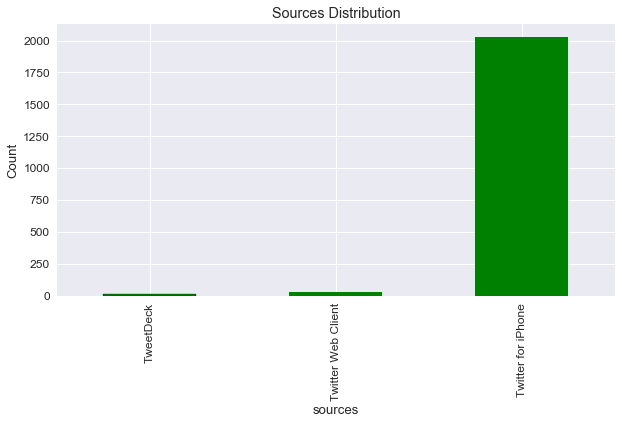

In [233]:
# Bar plot to see the sources distribution
source.plot(kind='bar',facecolor='green',edgecolor='black',figsize=(10, 5))
plt.ylabel('Count')
plt.title('Sources Distribution')
plt.show();
plt.rc('figure', figsize=(10, 10));

- It can be clearly seen that mostly, people use twitte by there phones.

In [268]:
master[master['rate']<2]['rate'].describe()

count    2064.000000
mean     1.058844   
std      0.218107   
min      0.000000   
25%      1.000000   
50%      1.100000   
75%      1.200000   
max      1.500000   
Name: rate, dtype: float64

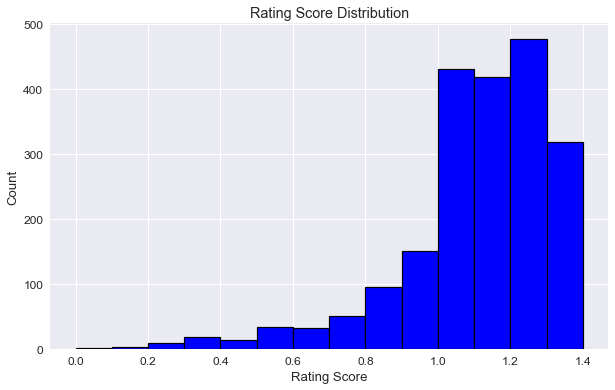

In [267]:
# Histogram of Rating_scores, only consider those twitter ids' rate that is lower than 2;
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4]
rates = master[master['rate']<2]['rate']
plt.hist(rates, bins,edgecolor='black', facecolor = 'blue',linewidth=1.2)
plt.xlabel('Rating Score')
plt.ylabel('Count')
plt.title('Rating Score Distribution')
plt.show()
plt.rc('figure', figsize=(10, 6));

- From the ploted figure above, we can see that the distribution is right skewed.
- The highest rate is 1.5 and the lowest rate is 0, the average rate is 1.058844.

In [275]:
total_gender = master['dog_gender'].dropna()
total_count = total_gender.count()
total_count

1251

In [272]:
dog_gender = master.groupby(['dog_gender'])['tweet_id'].count()
dog_gender

dog_gender
Female    239 
male      1012
Name: tweet_id, dtype: int64

In [280]:
master_gender = master.dropna(subset=['dog_gender'], how='any',axis=0)
master_gender = master_gender.reset_index(drop=True)
master_gender = master_gender[master_gender['rate']<2]

In [283]:
total_gender = master_gender['dog_gender'].count()
total_gender

1248

In [284]:
dog_gender = master_gender.groupby(['dog_gender'])['tweet_id'].count()
dog_gender

dog_gender
Female    238 
male      1010
Name: tweet_id, dtype: int64

In [287]:
dog_gender_counts = master_gender.groupby(['dog_gender','rate'])['tweet_id'].count()
dog_gender_counts

dog_gender  rate    
Female      0.400000    1  
            0.500000    1  
            0.600000    1  
            0.700000    1  
            0.800000    4  
            0.818182    1  
            0.900000    15 
            1.000000    39 
            1.100000    53 
            1.200000    66 
            1.300000    50 
            1.400000    6  
male        0.200000    2  
            0.300000    11 
            0.400000    4  
            0.500000    13 
            0.600000    18 
            0.636364    1  
            0.700000    30 
            0.800000    61 
            0.900000    71 
            1.000000    217
            1.100000    224
            1.200000    216
            1.300000    128
            1.400000    14 
Name: tweet_id, dtype: int64

In [294]:
dog_gender['Female']

238

In [298]:
proportion_female = dog_gender_counts['Female']/dog_gender['Female']
proportion_female

rate
0.400000    0.004202
0.500000    0.004202
0.600000    0.004202
0.700000    0.004202
0.800000    0.016807
0.818182    0.004202
0.900000    0.063025
1.000000    0.163866
1.100000    0.222689
1.200000    0.277311
1.300000    0.210084
1.400000    0.025210
Name: tweet_id, dtype: float64

In [299]:
dog_gender['male']

1010

In [300]:
proportion_male = dog_gender_counts['male']/dog_gender['male']
proportion_male

rate
0.200000    0.001980
0.300000    0.010891
0.400000    0.003960
0.500000    0.012871
0.600000    0.017822
0.636364    0.000990
0.700000    0.029703
0.800000    0.060396
0.900000    0.070297
1.000000    0.214851
1.100000    0.221782
1.200000    0.213861
1.300000    0.126733
1.400000    0.013861
Name: tweet_id, dtype: float64

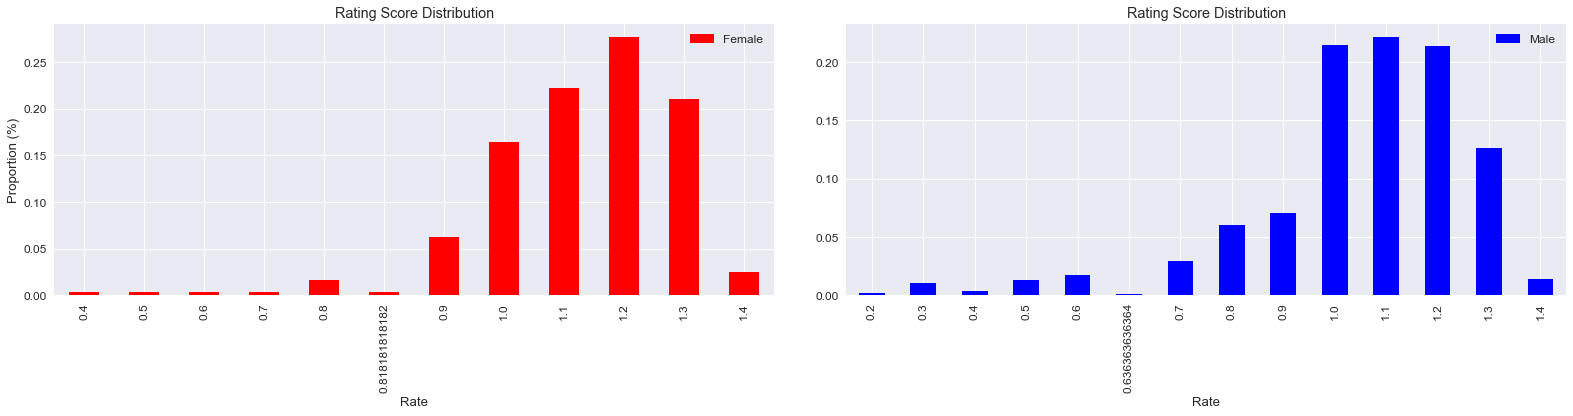

In [302]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax1 = proportion_female.plot(kind='bar', color='red',label='Female')
plt.xlabel('Rate')
plt.ylabel('Proportion (%)')
plt.title('Rating Score Distribution')
plt.legend()

ax2 = fig.add_subplot(122)
ax2 = proportion_male.plot(kind='bar',label='Male',color='blue')
plt.xlabel('Rate')
plt.title('Rating Score Distribution')
plt.legend()

plt.subplots_adjust(left=0.1,right=1.5,wspace=0.1)
plt.show()

- Limit the rate less thant 2;
- Divide the dog gender and plot the rate separately, we can see that there is a bit difference between the female and male dog.
- For female, the highest rate is 1.2, for male dog, the highest rate is 1.1.

In [303]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 17 columns):
tweet_id                  2070 non-null int64
text                      2070 non-null object
expanded_urls             2070 non-null object
rating_numerator          2070 non-null float64
rating_denominator        2070 non-null float64
dog_stage                 2070 non-null object
dog_gender                1251 non-null object
jpg_url                   2070 non-null object
algorithm_prediction      1746 non-null object
algorithm_confidential    2070 non-null float64
favorites                 2070 non-null int64
user_followers            2070 non-null int64
user_friends              2070 non-null int64
date_time                 2070 non-null object
sources                   2070 non-null object
Name                      1370 non-null object
rate                      2070 non-null float64
dtypes: float64(4), int64(4), object(9)
memory usage: 275.0+ KB


In [312]:
Times = master.dropna(subset=['date_time'], how='any',axis=0)['date_time']

In [418]:
year = []
month = []
hour = []
day_of_week = []
for time in Times:
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dt = datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
    year.append(dt.year)
    month.append(dt.month)
    hour.append(dt.hour)
    day_of_week.append(weekdays[dt.weekday()])

In [413]:
Year = {}
for i in year:
    if i not in Year:
        Year[i] = 1
    else:
        Year[i] += 1

In [419]:
Month = {}
for j in month:
    if j not in Month:
        Month[j] = 1
    else:
        Month[j] += 1    
m = sorted(Month.items())
month_x = []
month_y = []
for month in m:
    month_x.append(month[0])
    month_y.append(month[1])

In [422]:
Hour = {}
for z in hour:
    if z not in Hour:
        Hour[z] = 1
    else:
        Hour[z] += 1
H = sorted(Hour.items())
hour_x = []
hour_y = []
for hour in H:
    hour_x.append(hour[0])
    hour_y.append(hour[1])
print(hour_x,hour_y)

[0, 1, 2, 3, 4, 5, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] [261, 294, 222, 178, 96, 26, 3, 2, 8, 93, 196, 164, 104, 86, 80, 76, 70, 111]


In [416]:
Day_of_week = {}
for day in day_of_week:
    if day not in Day_of_week:
        Day_of_week[day] = 1
    else:
        Day_of_week[day] += 1

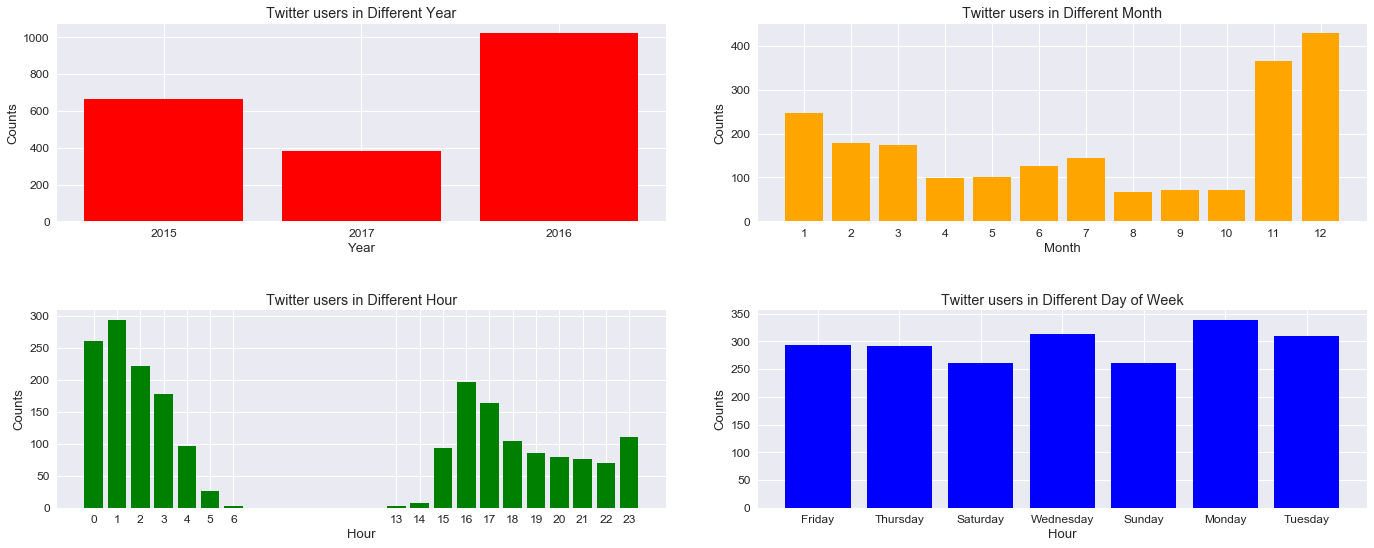

In [424]:
fig = plt.figure(figsize=(13,8))
plt.tight_layout()

ax1 = fig.add_subplot(221)
years = list(Year.keys())
years_values = list(Year.values())
ax1 = plt.bar(range(len(years)),years_values,tick_label=years, facecolor = 'red')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.title('Twitter users in Different Year')
plt.legend()


ax2 = fig.add_subplot(222)
ax2 = plt.bar(month_x,month_y,tick_label=month_x, facecolor = 'orange')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.title('Twitter users in Different Month')
plt.legend()


ax3 = fig.add_subplot(223)
# hours = list(Hour.keys())
# hours_values = list(Hour.values())
ax3 = plt.bar(hour_x,hour_y,tick_label=hour_x, facecolor = 'green')
plt.xlabel('Hour')
plt.ylabel('Counts')
plt.title('Twitter users in Different Hour')
plt.legend()


ax4 = fig.add_subplot(224)
weeks = list(Day_of_week.keys())
weeks_values = list(Day_of_week.values())
ax4 = plt.bar(range(len(weeks)),weeks_values,tick_label=weeks, facecolor = 'blue')
plt.xlabel('Hour')
plt.ylabel('Counts')
plt.title('Twitter users in Different Day of Week')
plt.legend()

# plt.subplots_adjust(left=0.1,right=1.5,wspace=0.1)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=1.5, hspace=0.45,
                    wspace=0.15)
plt.show();

- In this data set, mostly the twitter id is collected from 2016;
- December has the highest user counts compared with the rest of other months;
- Between 7:00 am - 12:00pm, there are no users use the twitter. Mostly, people use the twitter at night.
- Monday has the a bit higher user counts compared with the other days of the week.

In [432]:
master_rate_less_than2 = master[master['rate']<2]
favo = master_rate_less_than2['favorites']
master_r = master_rate_less_than2['rate']

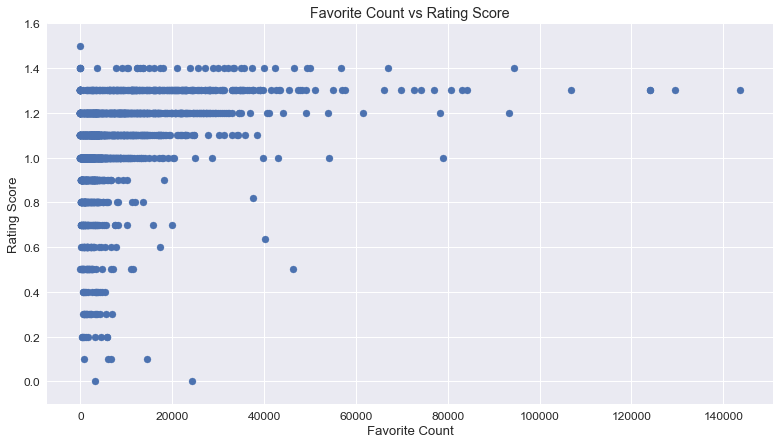

In [447]:
fig = plt.figure(figsize=(13,7))
plt.scatter(favo, master_r)
plt.ylim(-0.1, 1.6)
plt.xlabel('Favorite Count');
plt.ylabel('Rating Score');
plt.title('Favorite Count vs Rating Score')
plt.show();

- The favorite count increases when the rating score increases.

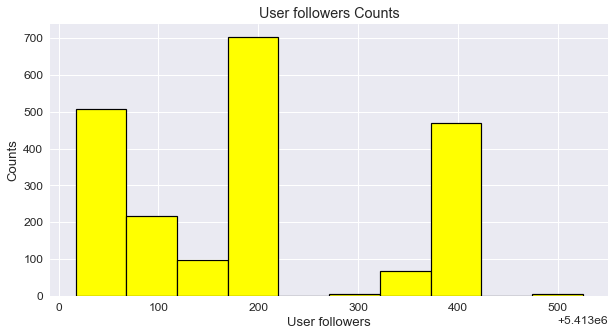

In [461]:
fig = plt.figure(figsize=(10,5))
followers = master['user_followers']
followers.hist(facecolor='yellow', edgecolor='black', linewidth = 1.2)
plt.xlabel('User followers');
plt.ylabel('Counts');
plt.title('User followers Counts')
plt.show();

In [450]:
followers.describe()

count    2.070000e+03
mean     5.413194e+06
std      1.299252e+02
min      5.413017e+06
25%      5.413068e+06
50%      5.413189e+06
75%      5.413370e+06
max      5.413525e+06
Name: user_followers, dtype: float64

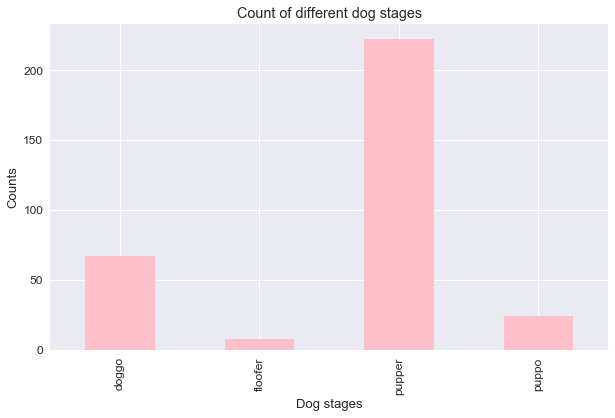

In [496]:
dog = master.replace(to_replace='None', value=np.nan)
dogs = dog.dropna(subset=['dog_stage'], how='any',axis=0)
dog_stages = dogs.groupby(['dog_stage'])['tweet_id'].count()
dog_stages.plot(kind='bar',facecolor ='pink')
plt.xlabel('Dog stages')
plt.ylabel('Counts')
plt.title('Count of different dog stages')
plt.show();

In [497]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 17 columns):
tweet_id                  2070 non-null int64
text                      2070 non-null object
expanded_urls             2070 non-null object
rating_numerator          2070 non-null float64
rating_denominator        2070 non-null float64
dog_stage                 2070 non-null object
dog_gender                1251 non-null object
jpg_url                   2070 non-null object
algorithm_prediction      1746 non-null object
algorithm_confidential    2070 non-null float64
favorites                 2070 non-null int64
user_followers            2070 non-null int64
user_friends              2070 non-null int64
date_time                 2070 non-null object
sources                   2070 non-null object
Name                      1370 non-null object
rate                      2070 non-null float64
dtypes: float64(4), int64(4), object(9)
memory usage: 275.0+ KB


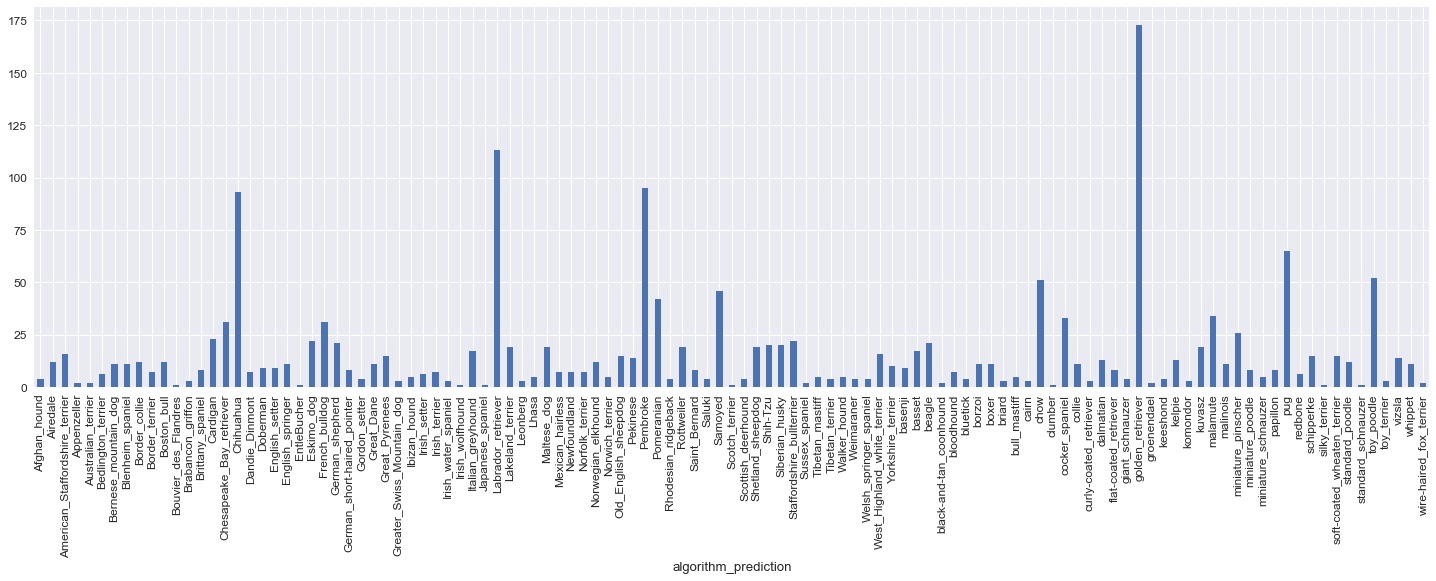

In [509]:
fig = plt.figure(figsize=(25,7))
algorithm = master.groupby(['algorithm_prediction'])['algorithm_confidential'].count()
algorithm.plot(kind='bar');

- Golden_retriever is the most commonly used prediction algorithm;
- The top three prediction algorithm is Golden retriever, Labrador retriver, and Pembroke;

## Conclusion
### 1. Data wrangling efforts 

Firstly, I gather all I needed data from handed file, related URL and through Twitter APIs, then I check with the data and find out some problems related to data quality and data tideness shown below:

**Quality: (Completeness, Validity, Accuracy, Consistency)**

**archive table**
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be intergs instead of float
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be changed to string because we don't use them for any numerical calculation
- retweeted_status_timestamp, timestamp should be datetime instead of object (string)
- The numerator and denominator columns have invalid values, the numerator may have outliers and the denominator minimum shows 0 which is invalid
- "name" column has invaled name such as "None, a, an, the, this"
- In 'doggo', 'floofer', 'pupper', 'puppo' columns, null objects are non-null(None to NaN)
- Column 'timestamp' in df_archive is same as column 'date_time' in tweet
- Make 'source' column more clear to read
**image_predictions table**
- Missing values from images dataset (2075 rows instead of 2356 compared to df_archive)
- We only want original ratings (no retweets) that have images
- Some tweet_ids have the same jpg_url

**Tidiness (Untidy data)**
- Drop column related to retweets, and unnecessary columns in images table
- Various stages of dogs in columns, it is better to use rows archives dataset 
- Add a gender column from the text columns in archives dataset

After that, I deal with the problems one by one, and merge the cleaned data to a new file store it to csv file.

### 2. Data acting efforts

I load the new cleaned data and explore the data to see the distribution of rating score and the difference between different dog gender; I also explore the data to see what is the different between year, month, hour, day of week for people using their twitter; Then I explore the relationship between rating score and favorate count, and it shows that with the increasing of the rating score, the favorate count increases; The distribution of dog stages, prediction algorithm are ploted, and the top three used algorithm is Golden retriever, Labrador retriver, and Pembroke.